# Simulate resting state dynamics in mouse brain

This demo shows how to simulate and analyze resting state dynamics in mouse brain using as connectome a tracer-based connectome built thanks to the Allen Connectivity Builder.

The results showed here are discussed in Melozzi et al., 2016 [1]



First, we import all the required dependencies

In [1]:
from tvb.simulator.lab import *
LOG = get_logger('demo')
from tvb.simulator.plot.tools import *
import numpy as np
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)


   INFO  NumExpr defaulting to 4 threads.
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor.state_variable_range = Final(field_type=<class 'dict'>, default={'x1': array([-2.,  1.]), 'y1': array([-20.,   2.]), 'z': array([2., 5.]), 'x2': array([-2.,  0.]), 'y2': array([0., 2.]), 'g': array([-1.,  1.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.epileptor.Epileptor2D.tt = NArray(label='tt', dtype=float64, default=array([1.]), dim_names=(), ndim=None, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor2D.state_variable_range = Final(field_type=<class 'dict'>, default={'x1': array([-2.,  1.]), 'z': array([2., 5.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
  

WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.stefanescu_jirsa.ReducedSetFitzHughNagumo.state_variable_range = Final(field_type=<class 'dict'>, default={'xi': array([-4.,  4.]), 'eta': array([-3.,  3.]), 'alpha': array([-4.,  4.]), 'beta': array([-3.,  3.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindmarshRose.a = NArray(label=':math:`a`', dtype=float64, default=array([1.]), dim_names=(), ndim=None, required=True)
WARNING  default contains values out of the declared domain. Ex 3.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindmarshRose.b = NArray(label=':math:`b`', dtype=float64, default=array([3.]), dim_names=(), ndim=None, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindma

## The Connectome

In order to built the mouse brain network we used a tracer-based connectome.

In particular we used a structural connectivity matrix (stored in the data folder of TVB), which is built thanks to the Allen Connectivity Builder in TVB.
The Allen Connectivity Builder is a tool that download and manipulate the open-source tracer experiments of the Allen Institute (Oh et al., 2014 [2]) in order to built a connectome and the corresponding parcelled volume according to the preferences of the user.

The user can choose:

  * the resolution of the grid volume in which the experimental data have been registered (here 100 $\mu m$).
  * The definition of the connection strength between source region $i$ and target region $j$. (here $w_{ij}=\frac{PD_j}{ID_i}$, where PD=projection density, ID=injection density)

It is possible to choose the characteristics of the brain areas to be included in the parcellation using the two following criteria:
 * Only brain areas where at least one injection has infected more than a given threshold of voxels. This kind of selection ensures that only the data with a certain level of experimental relevance is included in the connectome (Oh et al., 2014[2]), (here 50 voxels).
 * Only brain areas that have a volume greater than a given threshold can be included (here 2$mm^3$).



In the following the connectome is loaded in plotted. 
  

/opt/conda/envs/tvb-run/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


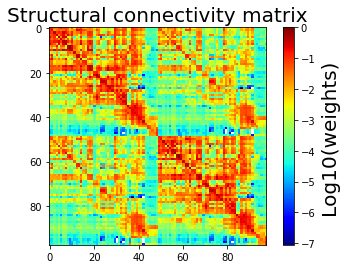

In [2]:
# Load the connectivity data from the directory tvb_data
con = connectivity.Connectivity.from_file("../mouse/allen_2mm/Connectivity.h5")

# Visualize the structural connectivity matrix
plt.subplots()
cs=plt.imshow(np.log10(con.weights), cmap='jet', aspect='equal', interpolation='none')
plt.title('Structural connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Log10(weights)', fontsize=20)


## The simulation

Once the brain network is defined is possible to simulate its activity. Here we simulate resting state dynamics using the reduced Wong Wang model (Deco et al. 2013 [3], Hansen et al., 2015 [4]).

In order to convert the synaptic activity in BOLD signals we used the Balloon-Windkessel method (Friston et al., 200 [5]) using the default value implemented in The Virtual Brain.

In [3]:
# Set the parameter of the resting state simulation
sim = simulator.Simulator(model=models.ReducedWongWang(w=numpy.array([1.0]), I_o=numpy.array([0.3])),
                        connectivity=con,
                        coupling=coupling.Linear(a=numpy.array([0.096])),
                        integrator=integrators.EulerStochastic(dt=0.1, noise=noise.Additive(nsig=numpy.array([0.000013]))),
                        monitors=(monitors.Bold(period=2e3),
                                  monitors.ProgressLogger(period=1e5)),
                        simulation_length=1200e3).configure()
# Run the resting state simulation
(bold_time, bold_data, ), _ = sim.run()

   INFO  step 1 time 0.0001 s
   INFO  step 1000001 time 100.0001 s
   INFO  step 2000001 time 200.0001 s
   INFO  step 3000001 time 300.0001 s
   INFO  step 4000001 time 400.0001 s
   INFO  step 5000001 time 500.0001 s
   INFO  step 6000001 time 600.0001 s
   INFO  step 7000001 time 700.0001 s
   INFO  step 8000001 time 800.0001 s
   INFO  step 9000001 time 900.0001 s
   INFO  step 10000001 time 1000.0001 s
   INFO  step 11000001 time 1100.0001 s


The simulated bold signals can be visualized using matplotlib library.

Text(0.5, 1.0, 'Simulated BOLD timeseries')

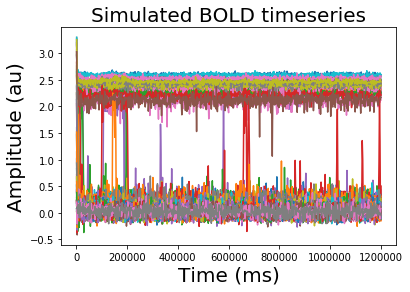

In [4]:
# Display the simulated bold timeseries
plt.subplots()
plt.plot(bold_time,bold_data[:,0,:,0])
plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Amplitude (au)', fontsize=20)
plt.title('Simulated BOLD timeseries', fontsize=20)

## Analysis

The simulated BOLD signals can be analyzed in different way. 

### Functional Connectivity Dynamics
In particular here we focus on the Functional Connectivity Dynamics (FCD) a metric which is able to quantify the evolution of the functional states in time. There are several ways to estimate FCD (for a review Preti et al., 2016 [6]), TVB uses the sliding windows technique.


In order to estimate the FCD using the sliding window technique, the entire BOLD time-series is divided in time windows of a fixed length (3 min) and with an overlap of 176 s; the data points within each window centered at the time $t_i$ were used to calculate FC($t_i$). 
The \emph{ij}-th element of the FCD matrix is calculated as the Pearson correlation between the upper triangular part of the $FC(t_i)$ matrix arranged as a vector and the upper triangular part of the $FC(t_j)$ matrix arranged as a vector.


The FCD matrix allows identifying the epochs of stable FC configurations as blocks of elevated inter-$FC(t)$ correlation; these blocks are organized around the diagonal of the FCD matrix (Hansen et al., 2015 [4]).


In order to identify the epochs of stable FC configurations, TVB uses the spectral embedding method, that permits to group together the nodes of the FCD, i.e. the different time windows, in clusters.

# TODO Fix FCD from here bellow

In [5]:
## Calculate the FCD matrix for the bold timeseries
import tvb.adapters.analyzers.fcd_adapter as fcd
from tvb.datatypes.time_series import TimeSeriesRegion

# Build the time series object
tsr = TimeSeriesRegion(connectivity=sim.connectivity,
                       data=bold_data,
                       sample_period=sim.monitors[0].period)
tsr.configure()

# Create and evaluate the analysis
wind_len=180e3 # windows length (ms)
wind_sp=4e3 # spanning between sliding windows (ms)
fcd_analyser = fcd.FcdCalculator(time_series=tsr, sw=wind_len, sp=wind_sp)
fcd_data = fcd_analyser.evaluate()

# Store the results
FCD=fcd_data[0][:,:,0,0]
FCD_segmented=fcd_data[1][:,:,0,0]

AttributeError: 'FcdCalculator' object has no attribute 'evaluate'

The original and segmented FCD matrices can be visualized using the matplotlib library.


In [ ]:
# Plot the FCD matrix and the FCD matrix segmented in the epochs
plt.subplot(121)
cs=plt.imshow(FCD, cmap='jet', aspect='equal')
axcb =plt.colorbar(ticks=[0, 0.5, 1])
axcb.set_label(r'CC [FC($t_i$), FC($t_j$)]', fontsize=20)
cs.set_clim(0, 1.0)
for t in axcb.ax.get_yticklabels():
     t.set_fontsize(18)
plt.xticks([0,len(FCD)/2-1, len(FCD)-1],['0','10', '20'], fontsize=18)
plt.yticks([0,len(FCD)/2-1, len(FCD)-1],['0','10', '20'], fontsize=18)
plt.xlabel(r'Time $t_j$ (min)', fontsize=20)
plt.ylabel(r'Time $t_i$ (min)', fontsize=20)
plt.title('FCD', fontsize=20)

plt.subplot(122)
cs=plt.imshow(FCD_segmented, cmap='jet', aspect='equal')
axcb =plt.colorbar(ticks=[0, 0.5, 1])
axcb.set_label(r'CC [FC($t_i$), FC($t_j$)]', fontsize=20)
cs.set_clim(0, 1.0)
for t in axcb.ax.get_yticklabels():
     t.set_fontsize(18)
plt.xticks([0,len(FCD)/2-1, len(FCD)-1],['0','10', '20'], fontsize=18)
plt.yticks([0,len(FCD)/2-1, len(FCD)-1],['0','10', '20'], fontsize=18)
plt.xlabel(r'Time $t_j$ (min)', fontsize=20)
plt.ylabel(r'Time $t_i$ (min)', fontsize=20)
plt.title('FCD segmented', fontsize=20)

### Functional hubs

The functional connectivity matrix of each epoch defines a functional network; for each functional network, TVB identifies the hub regions with an approach analogous to the one used in graph theory for defining the eigenvector centrality of a network node (Newman 2008 [7]). 

Here the functional hub regions of the mouse brain are defined as the regions with the largest eigenvector components, in absolute value, associated with the three largest eigenvalues of the FC matrix.


The functional hubs are an output of the FCD function (that we have just run), so we can save the results and display them in the mouse brain sections.

In [ ]:
# Save the functional hubs calculated as output of the FCD function
Eigvect_dict=fcd_data[2]
Eigval_dict=fcd_data[3]

# Plot the functional hubs extracted in the epochs

import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tvb.basic.readers import try_get_absolute_path

fig, axes = plt.subplots(3,3)

mode=0
var=0
count=1
slice_idy=73
for ep in range(3):
    for eigval in range(3):
        f_path = try_get_absolute_path("tvb_data", "mouse/allen_2mm/RegionVolumeMapping.h5")
        print ("trying to read ", f_path)
        f = h5py.File(f_path, 'r', libver='latest')
        Vol=f['array_data'][:,:,:]
        f_path = try_get_absolute_path("tvb_data", "mouse/allen_2mm/StructuralMRI.h5")
        f = h5py.File(f_path, 'r', libver='latest')
        template=f['array_data'][:,:,:]
        lambda_=Eigval_dict[mode][var][ep+1][eigval]
        eig=Eigvect_dict[mode][var][ep+1][eigval] 

        for i in range(np.shape(eig)[0]):
            Vol[Vol==i]=eig[i]
        Vol = np.ma.masked_where(Vol < (np.amax(eig)/2), Vol)        
        im1 = axes[ep,eigval].imshow((template[:,slice_idy,:].T)[::-1], cmap='gray', vmin=template.min(), vmax=template.max())
        cax = axes[ep,eigval].imshow((Vol[:,slice_idy,:].T)[::-1], cmap='YlOrRd', alpha=1, vmin=np.amax(eig)/2., vmax=np.amax(eig))
        axes[ep,eigval].axis('off')
        axes[ep,eigval].set_title(r'Epoch %s, $\lambda$ = %1.3f'%(ep+1,lambda_))
        divider = make_axes_locatable(axes[ep,eigval])
        cax1 = divider.append_axes("right", size="5%", pad=0.05)
        axcb=plt.colorbar(cax,cax1,ticks=[np.amax(eig)/2.,np.amax(eig)],orientation='vertical')
        axcb.set_ticklabels(['Max/2', 'Max']) 
        axcb.set_label('Eigenvector components')

## References

[1] Melozzi, Francesca, Marmaduke Woodman, Viktor Jirsa, and Christophe Bernard. "The Virtual Mouse Brain: A Computational Neuroinformatics Platform To Study Whole Mouse Brain Dynamics." bioRxiv (2017): 123406.


[2] Oh, Seung Wook, Julie A. Harris, Lydia Ng, Brent Winslow, Nicholas Cain, Stefan Mihalas, Quanxin Wang et al. "A mesoscale connectome of the mouse brain." Nature 508, no. 7495 (2014): 207-214.


[3] Deco Gustavo, Ponce Alvarez Adrian, Dante Mantini, Gian Luca Romani, Patric Hagmann and Maurizio Corbetta. Resting-State Functional Connectivity Emerges from Structurally and Dynamically Shaped Slow Linear Fluctuations. The Journal of Neuroscience 32(27), 11239-11252, 2013.


[4] Hansen, Enrique CA, Demian Battaglia, Andreas Spiegler, Gustavo Deco, and Viktor K. Jirsa. "Functional connectivity dynamics: modeling the switching behavior of the resting state." Neuroimage 105 (2015): 525-535.


[5] Friston, Karl J., Andrea Mechelli, Robert Turner, and Cathy J. Price. "Nonlinear responses in fMRI: the Balloon model, Volterra kernels, and other hemodynamics." NeuroImage 12, no. 4 (2000): 466-477.


[6] Preti, Maria Giulia, Thomas AW Bolton, and Dimitri Van De Ville. "The dynamic functional connectome: State-of-the-art and perspectives." NeuroImage (2016).


[7] Newman, Mark EJ. "The mathematics of networks." The new palgrave encyclopedia of economics 2, no. 2008 (2008): 1-12.